In [1]:
import numpy as np
from scipy import stats as ss
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from scipy.stats import norm
from scipy.stats import multivariate_normal 
from scipy import stats as ss

from BayersianModel import BayersianModel
from Prior import Prior
from copy import deepcopy
import pandas as pd
import os
from MCMC import NaiveSampler

In [2]:
normal2d = np.random.multivariate_normal

# testing the sampling method

this notebook aims to test the correctness of my naive sampler by doing some quantitative analysis on the 2d gaussian. 

#### testing the sampler: correctness and efficiency
- compute effective sample size: i think warne has done this to his experiement 
- could there be a chi-square way, null hypothesis etc way of testing the confidence of this sampler? 
    - this works for independent samples, probabily not good for mcmc
    - this could work for 2d. 
- moment method
- summary statistics: this is the most easy way....
- auto-correlation might also be very helpful

In [3]:
# parameters
m0 = 0
m1 = 1
c00 = 16
c01 = 0
c10 = 0
c11 = 25
mean = np.array([m0,m1])
cov  = np.array([[c00,c01],[c10,c11]])
sample_size = 20

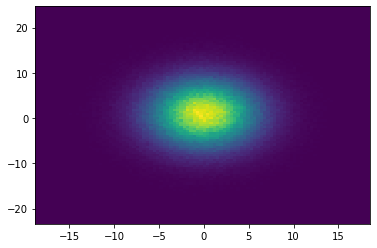

In [4]:
# large_observation to see the distribution of this 2d normal
large_observation = normal2d(mean,cov,1000000)
plt.hist2d(large_observation[:,0],large_observation[:,1],bins=(100,100))
print()

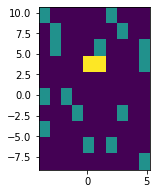

In [5]:
# observation
observation = normal2d(mean,cov,sample_size)
plt.figure(figsize=(2,3))
plt.hist2d(observation[:,0],observation[:,1])
print()

## parameter estimation

there are in total 5 parameters of a 2d gaussian distribution. they are
$$
\mu_0=0,\quad\mu_1=1,\quad c_{0,0}=16,\quad c_{0,1}= c_{1,0}=0,\quad c_{1,1}=25
$$

I will give the true value of $c_{1,0} = c_{0,1} =0$ as prior to the sampler, and let it only guessing what are $\mu_0, \mu_1 , c_{0,0}, c_{1,1}$. 


#### Parameter search space

Notice that in the current case, the parameter has the following constrictions

- $c_{00}, c_{11} \ge 0$

Otherwise the covariance matrix is not positive semi-definite. 

- The sampling of prior is easy: just limit it to some boxes will be fine. 

I will simply restict that 
- $\mu_{0},\mu_{1} \in [-10,10]$
- $c_{1,1} \in [0,100]$
- $c_{0,0}' \in [0,100]$

<!-- - but for the proposal function, can actually be a bit tricky. My method around it is described in the `MCMC.naive_sampler.proposal.'constraint'` right now. It could be a little biased.  -->

In [6]:
theta_range = np.array(((-10,10),(-10,10),(0.1,50),(0.1,50))).T

In [13]:
def flatten(theta):
    '''
    theta = mean, cov
    return 1d array
    '''
    return np.concatenate([np.array(t).flatten() for t in theta])

def reshape(arr):
    '''
    arr = (m0,m1,c00,c11)
    return mean, cov
    '''
    m0,m1,c00,c11 = arr
    return (
        np.array([m0,m1]),
        np.array([[c00,c01],[c10,c11]])
        )

def sampler():
  return np.random.uniform(*theta_range)

def constraint(theta):
  '''
  the cov is required to be symmetric positive definite. 
  this function checks if it is the case. 
  '''
  cov = reshape(theta)[1]
  return np.linalg.det(cov) > 0 and np.trace(cov) > 0


def log_likelyhood(theta, observation):
    '''
    Inputs
      - theta = (mu,cov)
      - observation = ...
      
    Output
      - likelyhood of L(theta, observation)
    '''
    theta_ = theta
    theta = reshape(theta)
    try:
      var = multivariate_normal(*theta)
    except ValueError:
      print(theta)
      assert(False)
    return np.product(var.pdf(observation))

## Inference

In [17]:
np.linalg.det([[-0.64488175,  0.        ],
       [ 0.        , 37.12288038]]) > 0

False

In [14]:
prior = Prior(
    log_pdf=lambda _:1,
    sampler=sampler,
    theta_range=theta_range
)
model = BayersianModel(
    prior=prior,
    observation=observation,
    log_likelyhood=log_likelyhood,
    )

naive_sampelr = NaiveSampler(
    model,
    burn_in=0
)

In [15]:
pst_samples = naive_sampelr.simulation(
    n=500000,
    theta_range='constraint',
    constraint=constraint,
    box_size=1)

sampling posterior:   0%|          | 595/500000 [00:00<01:41, 4912.19it/s]

(array([-27.37016407,  10.06634619]), array([[-0.64488175,  0.        ],
       [ 0.        , 37.12288038]]))


AssertionError: 

In [ ]:
M1,M2,C1,C2, = pst_samples.T

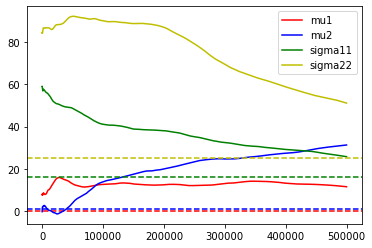

In [ ]:
plt.plot((M1.cumsum() / np.arange(1, len(M1)+1)),c='r',label='mu1')
plt.axhline(0,c='r',linestyle='--')
plt.plot((M2.cumsum() / np.arange(1, len(M1)+1)),c='b',label='mu2')
plt.axhline(1,c='b',linestyle='--')
plt.plot((C1.cumsum() / np.arange(1, len(M1)+1)),c='g',label='sigma11')
plt.axhline(16,c='g',linestyle='--')
plt.plot((C2.cumsum() / np.arange(1, len(M1)+1)),c='y',label='sigma22')
plt.axhline(25,c='y',linestyle='--')
plt.legend()


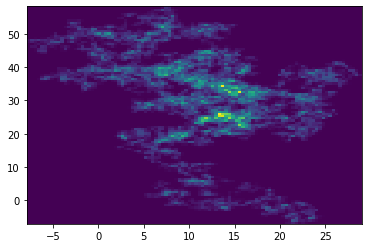

In [ ]:
plt.hist2d(M1,M2,bins=(100,100))
print()